# 1. INSTALL REQUIRED LIBRARIES

In [ ]:
!pip install bertopic
!pip install sentence-transformers
!pip install umap-learn
!pip install hdbscan
!pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

#2. IMPORT LIBRARIES**


In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Libraries untuk text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Libraries untuk BERTopic
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer

# 3. LOAD DATA


In [ ]:
print("📊 Loading data...")
df = pd.read_csv('Sunnah.csv')
print(f"✅ Data loaded successfully!")
print(f"📋 Shape: {df.shape}")
print(f"📑 Columns: {df.columns.tolist()}")

📊 Loading data...
✅ Data loaded successfully!
📋 Shape: (38101, 3)
📑 Columns: ['Perawi', 'Arab', 'Terjemahan']


# 4. EXPLORATORY DATA ANALYSIS (EDA)


In [ ]:
print("\n" + "="*50)
print("📈 EXPLORATORY DATA ANALYSIS")
print("="*50)

# Basic info
print(f"📊 Dataset Info:")
print(f"   - Total hadits: {len(df):,}")
print(f"   - Missing values per column:")
for col in df.columns:
    missing = df[col].isnull().sum()
    print(f"     {col}: {missing:,} ({missing/len(df)*100:.1f}%)")

# Sample data
print(f"\n📖 Sample hadits:")
for i in range(3):
    print(f"\n{i+1}. Perawi: {df.iloc[i]['Perawi']}")
    print(f"   Terjemahan: {df.iloc[i]['Terjemahan'][:100]}...")


📈 EXPLORATORY DATA ANALYSIS
📊 Dataset Info:
   - Total hadits: 38,101
   - Missing values per column:
     Perawi: 1 (0.0%)
     Arab: 1 (0.0%)
     Terjemahan: 1 (0.0%)

📖 Sample hadits:

1. Perawi: Hadits Abu Daud Nomor 1
   Terjemahan: Telah menceritakan kepada kami [Abdullah bin Maslamah bin Qa'nab al Qa'nabi] telah menceritakan kepa...

2. Perawi: Hadits Abu Daud Nomor 2
   Terjemahan: Telah menceritakan kepada kami [Musaddad bin Musarhad] telah menceritakan kepada kami [Isa bin Yunus...

3. Perawi: Hadits Abu Daud Nomor 3
   Terjemahan: Telah menceritakan kepada kami [Musa bin Isma'il] telah menceritakan kepada kami [Hammad] telah meng...


**DATA CLEANING FUNCTION**


In [ ]:
def clean_indonesian_text(text):
    """
    Fungsi untuk membersihkan teks hadits bahasa Indonesia
    """
    if pd.isna(text):
        return ""

    # Convert to string and lowercase
    text = str(text).lower()

    # Remove brackets and their contents (seperti [nama perawi])
    text = re.sub(r'\[.*?\]', '', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text)

    # Remove leading/trailing whitespace
    text = text.strip()

    return text

def remove_indonesian_stopwords(text):
    """
    Fungsi untuk menghapus stopwords bahasa Indonesia
    """
    # Stopwords bahasa Indonesia yang umum dalam hadits
    indonesian_stopwords = [
        'telah', 'menceritakan', 'kepada', 'kami', 'dari', 'bin', 'ibn', 'abu',
        'yang', 'dan', 'adalah', 'dengan', 'untuk', 'dalam', 'pada', 'itu',
        'ini', 'dia', 'mereka', 'kita', 'saya', 'aku', 'engkau', 'kamu',
        'beliau', 'ia', 'nya', 'juga', 'akan', 'telah', 'sudah', 'sedang',
        'bahwa', 'jika', 'apabila', 'ketika', 'saat', 'waktu', 'kemudian',
        'lalu', 'maka', 'sehingga', 'hingga', 'sampai', 'atau', 'tetapi',
        'namun', 'karena', 'sebab', 'oleh', 'bagi', 'tentang', 'mengenai',
        'terhadap', 'atas', 'bawah', 'depan', 'belakang', 'kiri', 'kanan'
    ]

    words = text.split()
    filtered_words = [word for word in words if word not in indonesian_stopwords]
    return ' '.join(filtered_words)

**APPLY CLEANING**


In [ ]:
print("\n" + "="*50)
print("🧹 DATA CLEANING")
print("="*50)

print("📝 Cleaning text...")
# Clean terjemahan column
df['cleaned_text'] = df['Terjemahan'].apply(clean_indonesian_text)
df['cleaned_text'] = df['cleaned_text'].apply(remove_indonesian_stopwords)

# Remove empty texts
df = df[df['cleaned_text'].str.len() > 10].reset_index(drop=True)

print(f"✅ Cleaning completed!")
print(f"📊 After cleaning: {len(df):,} hadits")

# Show cleaning results
print(f"\n📖 Sample cleaned text:")
for i in range(3):
    print(f"\n{i+1}. Original: {df.iloc[i]['Terjemahan'][:100]}...")
    print(f"   Cleaned:  {df.iloc[i]['cleaned_text'][:100]}...")



🧹 DATA CLEANING
📝 Cleaning text...
✅ Cleaning completed!
📊 After cleaning: 38,100 hadits

📖 Sample cleaned text:

1. Original: Telah menceritakan kepada kami [Abdullah bin Maslamah bin Qa'nab al Qa'nabi] telah menceritakan kepa...
   Cleaned:  bahwasanya nabi shallallahu 'alaihi wasallam hendak pergi buang hajat, menjauh....

2. Original: Telah menceritakan kepada kami [Musaddad bin Musarhad] telah menceritakan kepada kami [Isa bin Yunus...
   Cleaned:  mengabarkan bahwasanya nabi shallallahu 'alaihi wasallam hendak buang hajat, pergi tidak ada seorang...

3. Original: Telah menceritakan kepada kami [Musa bin Isma'il] telah menceritakan kepada kami [Hammad] telah meng...
   Cleaned:  mengabarkan berkata; berkata; tatkala abdullah abbas datang ke bashrah, hadits , abdullah menulis su...


TEXT LENGTH ANALYSIS



📏 TEXT LENGTH ANALYSIS
📊 Text Statistics:
   - Average text length: 445 characters
   - Average word count: 55 words
   - Min word count: 2
   - Max word count: 1665


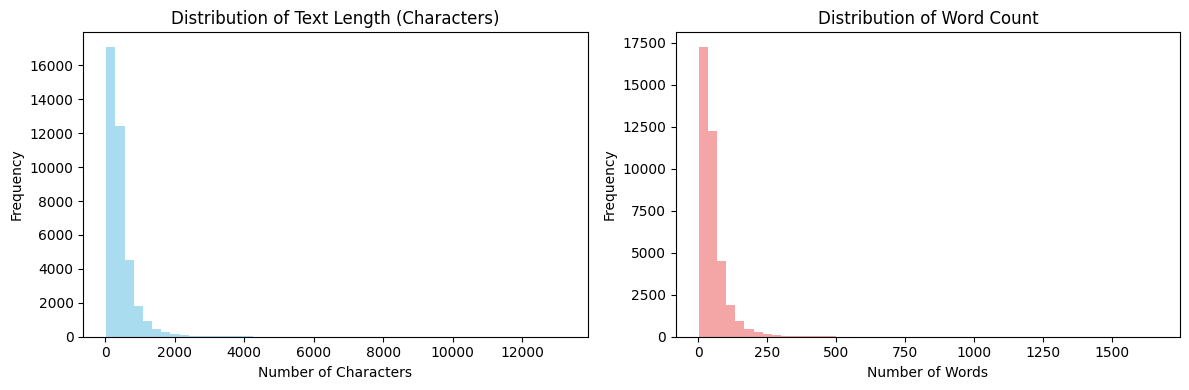

In [ ]:
print("\n" + "="*50)
print("📏 TEXT LENGTH ANALYSIS")
print("="*50)

df['text_length'] = df['cleaned_text'].str.len()
df['word_count'] = df['cleaned_text'].str.split().str.len()

print(f"📊 Text Statistics:")
print(f"   - Average text length: {df['text_length'].mean():.0f} characters")
print(f"   - Average word count: {df['word_count'].mean():.0f} words")
print(f"   - Min word count: {df['word_count'].min()}")
print(f"   - Max word count: {df['word_count'].max()}")

# Plot text length distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df['text_length'], bins=50, alpha=0.7, color='skyblue')
plt.title('Distribution of Text Length (Characters)')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df['word_count'], bins=50, alpha=0.7, color='lightcoral')
plt.title('Distribution of Word Count')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

**SAMPLE DATA FOR CLUSTERING**


In [ ]:
print("\n" + "="*50)
print("🎯 PREPARE DATA FOR CLUSTERING")
print("="*50)

# Atau gunakan semua data
df_sample = df.copy()
print(f"📊 Using all {len(df_sample):,} hadits")

# Prepare documents for clustering
documents = df_sample['cleaned_text'].tolist()

print(f"✅ Documents prepared for clustering!")
print(f"📋 Total documents: {len(documents):,}")
print(f"📄 First document: {documents[0][:150]}...")


🎯 PREPARE DATA FOR CLUSTERING
📊 Using all 38,100 hadits
✅ Documents prepared for clustering!
📋 Total documents: 38,100
📄 First document: bahwasanya nabi shallallahu 'alaihi wasallam hendak pergi buang hajat, menjauh....


**SAVE PREPROCESSED DATA**


In [ ]:
print("\n" + "="*50)
print("💾 SAVING PREPROCESSED DATA")
print("="*50)

df_sample.to_csv('hadits_preprocessed.csv', index=False)
print(f"✅ Preprocessed data saved as 'hadits_preprocessed.csv'")

print("\n" + "="*50)
print("🎉 DATA PREPARATION COMPLETED!")
print("="*50)
print(f"📊 Summary:")
print(f"   - Original hadits: {df.shape[0]:,}")
print(f"   - After cleaning: {len(df_sample):,}")
print(f"   - Ready for clustering: ✅")
print(f"   - Next step: BERTopic model training")


💾 SAVING PREPROCESSED DATA
✅ Preprocessed data saved as 'hadits_preprocessed.csv'

🎉 DATA PREPARATION COMPLETED!
📊 Summary:
   - Original hadits: 38,100
   - After cleaning: 38,100
   - Ready for clustering: ✅
   - Next step: BERTopic model training


# 4. BERTOPIC MODEL TRAINING - CLUSTERING HADITS

1. SETUP SENTENCE TRANSFORMER


In [ ]:
print("🔧 Setting up Sentence Transformer...")
# Menggunakan model multilingual yang bagus untuk bahasa Indonesia
sentence_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
print("✅ Sentence Transformer ready!")

🔧 Setting up Sentence Transformer...


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Sentence Transformer ready!


2. SETUP UMAP (Dimensionality Reduction)


In [ ]:
print("🔧 Setting up UMAP...")
umap_model = UMAP(
    n_neighbors=15,      # Jumlah tetangga terdekat
    n_components=5,      # Dimensi output
    min_dist=0.0,        # Jarak minimum antar titik
    metric='cosine',     # Metrik jarak
    random_state=42
)
print("✅ UMAP ready!")

🔧 Setting up UMAP...
✅ UMAP ready!


3. SETUP HDBSCAN (Clustering Algorithm)


In [ ]:
print("🔧 Setting up HDBSCAN...")
hdbscan_model = HDBSCAN(
    min_cluster_size=15,     # Ukuran minimum cluster
    metric='euclidean',      # Metrik jarak
    cluster_selection_method='eom',  # Metode seleksi cluster
    prediction_data=True
)
print("✅ HDBSCAN ready!")

🔧 Setting up HDBSCAN...
✅ HDBSCAN ready!


4. SETUP VECTORIZER (untuk representasi topik)


In [ ]:
print("🔧 Setting up Vectorizer...")
vectorizer_model = CountVectorizer(
    ngram_range=(1, 2),      # Unigram dan bigram
    stop_words=None,         # Kita sudah remove stopwords
    min_df=2,                # Minimum document frequency
    max_df=0.9               # Maximum document frequency
)
print("✅ Vectorizer ready!")

🔧 Setting up Vectorizer...
✅ Vectorizer ready!


5. CREATE BERTOPIC MODEL


In [ ]:
print("\n" + "="*50)
print("🏗️ CREATING BERTOPIC MODEL")
print("="*50)

topic_model = BERTopic(
    embedding_model=sentence_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    calculate_probabilities=True,  # Untuk mendapatkan probabilitas topik
    verbose=True
)

print("✅ BERTopic model created!")


🏗️ CREATING BERTOPIC MODEL
✅ BERTopic model created!


6. TRAIN THE MODEL


In [ ]:
print("\n" + "="*50)
print("🚀 TRAINING BERTOPIC MODEL")
print("="*50)
print("⏳ This may take several minutes...")

# Fit model pada dokumen
topics, probs = topic_model.fit_transform(documents)

print(f"✅ Model training completed!")
print(f"📊 Results:")
print(f"   - Number of topics found: {len(set(topics)) - (1 if -1 in topics else 0)}")
print(f"   - Documents with topics: {len([t for t in topics if t != -1])}")
print(f"   - Outliers (topic -1): {len([t for t in topics if t == -1])}")

2025-07-03 14:32:27,552 - BERTopic - Embedding - Transforming documents to embeddings.



🚀 TRAINING BERTOPIC MODEL
⏳ This may take several minutes...


Batches:   0%|          | 0/1191 [00:00<?, ?it/s]

2025-07-03 15:25:59,677 - BERTopic - Embedding - Completed ✓
2025-07-03 15:25:59,680 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-03 15:27:20,040 - BERTopic - Dimensionality - Completed ✓
2025-07-03 15:27:20,043 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-03 15:32:38,821 - BERTopic - Cluster - Completed ✓
2025-07-03 15:32:38,856 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-03 15:32:45,257 - BERTopic - Representation - Completed ✓


✅ Model training completed!
📊 Results:
   - Number of topics found: 300
   - Documents with topics: 17671
   - Outliers (topic -1): 20429


7. ANALYZE RESULTS


In [ ]:
print("\n" + "="*50)
print("📈 TOPIC ANALYSIS")
print("="*50)

# Topic frequency
topic_freq = topic_model.get_topic_freq()
print(f"📊 Top 10 topics by frequency:")
print(topic_freq.head(10))

# Topic information
topic_info = topic_model.get_topic_info()
print(f"\n📋 Topic information:")
print(topic_info.head())



📈 TOPIC ANALYSIS
📊 Top 10 topics by frequency:
    Topic  Count
0      -1  20429
7       0   1124
10      1    511
22      2    489
35      3    450
77      4    396
27      5    362
9       6    337
45      7    330
41      8    262

📋 Topic information:
   Topic  Count                                               Name  \
0     -1  20429                             -1_allah_kalian_al_ada   
1      0   1124                     0_matahari_malam_shalat_rakaat   
2      1    511                   1_rambut_rambutnya_mencukur_bulu   
3      2    489  2_mengangkat_kedua_mengangkat kedua_kedua tang...   
4      3    450                        3_makanan_makan_daging_roti   

                                      Representation  \
0  [allah, kalian, al, ada, menjawab, wahai, laki...   
1  [matahari, malam, shalat, rakaat, tidur, subuh...   
2  [rambut, rambutnya, mencukur, bulu, kumis, mem...   
3  [mengangkat, kedua, mengangkat kedua, kedua ta...   
4  [makanan, makan, daging, roti, memakann

8. DISPLAY TOP TOPICS


In [ ]:
print("\n" + "="*50)
print("🏷️ TOP TOPICS DETAILS")
print("="*50)

for topic_id in range(min(5, len(topic_freq))):  # Show top 5 topics
    if topic_id == 0 and -1 in topics:  # Skip outlier topic
        continue

    topic_words = topic_model.get_topic(topic_id)
    print(f"\n📍 Topic {topic_id}:")
    print(f"   Words: {', '.join([word for word, score in topic_words[:10]])}")

    # Show sample documents from this topic
    topic_docs_idx = [i for i, t in enumerate(topics) if t == topic_id]
    sample_docs = topic_docs_idx[:3]  # Take 3 sample documents

    print(f"   Sample hadits:")
    for i, doc_idx in enumerate(sample_docs):
        print(f"   {i+1}. {documents[doc_idx][:100]}...")


🏷️ TOP TOPICS DETAILS

📍 Topic 1:
   Words: rambut, rambutnya, mencukur, bulu, kumis, memotong, jenggot, memendekkan, memotong kuku, mencukur rambut
   Sample hadits:
   1. ibnu abdurrahman, berkata; pernah bertemu nabi shallallahu 'alaihi wasallam sebagaimana hurairah ber...
   2. berkata; rasulullah shallallahu 'alaihi wasallam bersabda: "sepuluh perkara termasuk fithrah: memoto...
   3. berdua berkata; bahwasanya rasulullah shallallahu 'alaihi wasallam pernah berwudhu di sisinya, mengu...

📍 Topic 2:
   Words: mengangkat, kedua, mengangkat kedua, kedua tangannya, tangannya, tangan, meletakkan, jari, sujud, rukuk
   Sample hadits:
   1. berkata; "tanganku tangan rasulullah shallallahu 'alaihi wasallam saling bergantian berwudhu satu be...
   2. berkata; pernah melihat rasulullah shallallahu 'alaihi wasallam berwudhu, menggosok jari-jari kedua ...
   3. berkata; pernah bertanya nabi shallallahu 'alaihi wasallam tayammum, memerintahkanku menepukkan satu...

📍 Topic 3:
   Words: makana

In [21]:
print("💾 9. SAVING RESULTS")

# Add topic assignments to dataframe
df_sample['topic'] = topics
df_sample['topic_probability'] = probs.max(axis=1) if probs is not None else None

# Save results
df_sample.to_csv('hadits_with_topics.csv', index=False)
print("✅ Results saved to 'hadits_with_topics.csv'")

# Save topic model
topic_model.save("hadits_topic_model")
print("✅ Topic model saved to 'hadits_topic_model'")

💾 9. SAVING RESULTS


2025-07-03 16:36:22,121 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


✅ Results saved to 'hadits_with_topics.csv'
✅ Topic model saved to 'hadits_topic_model'


📊 10. CREATING VISUALIZATIONS


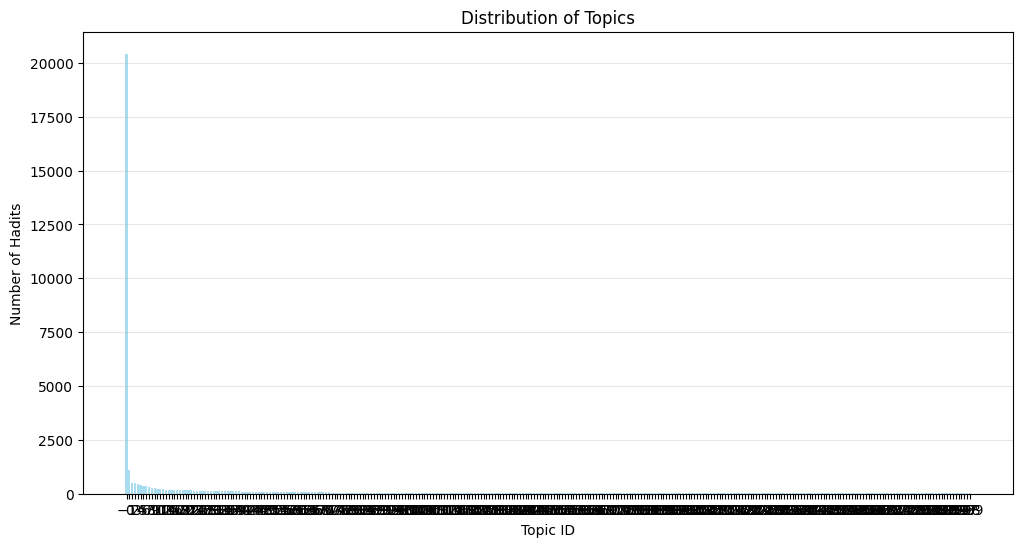


📊 Creating topic keywords visualization...



📊 Creating topic similarity heatmap...



📊 Creating intertopic distance map...


In [23]:
print("📊 10. CREATING VISUALIZATIONS")

# Topic distribution
plt.figure(figsize=(12, 6))
topic_counts = Counter(topics)
topics_list = list(topic_counts.keys())
counts_list = list(topic_counts.values())

plt.bar(topics_list, counts_list, color='skyblue', alpha=0.7)
plt.title('Distribution of Topics')
plt.xlabel('Topic ID')
plt.ylabel('Number of Hadits')
plt.xticks(topics_list)
plt.grid(axis='y', alpha=0.3)
plt.show()

# Show topic keywords heatmap
print("\n📊 Creating topic keywords visualization...")
fig = topic_model.visualize_barchart(n_words=10)
fig.show()

# Show topic similarity heatmap
print("\n📊 Creating topic similarity heatmap...")
fig = topic_model.visualize_heatmap()
fig.show()

# Show intertopic distance map
print("\n📊 Creating intertopic distance map...")
fig = topic_model.visualize_topics()
fig.show()

In [26]:
print("📋 11. DETAILED TOPIC ANALYSIS")

# Create topic summary
topic_summary = []
# Iterate through unique topic IDs, excluding -1
for topic_id in sorted(list(set(topics))):
    if topic_id == -1:  # Skip outlier topic
        continue

    topic_words = topic_model.get_topic(topic_id)
    topic_docs_idx = [i for i, t in enumerate(topics) if t == topic_id]

    # Get representative document (highest probability)
    best_doc_idx = None
    if topic_docs_idx:
        best_doc_idx = topic_docs_idx[0]
        if probs is not None:
            # Ensure topic_id is a valid index for probabilities
            if topic_id < probs.shape[1]:
                prob_scores = [probs[i][topic_id] for i in topic_docs_idx]
                best_doc_idx = topic_docs_idx[np.argmax(prob_scores)]
            else:
                 # Fallback if topic_id is unexpectedly out of bounds for probs
                 print(f"Warning: Topic ID {topic_id} out of bounds for probabilities. Using first document as representative.")
                 best_doc_idx = topic_docs_idx[0]


    topic_summary.append({
        'Topic': topic_id,
        'Size': len(topic_docs_idx),
        'Top_Words': ', '.join([word for word, score in topic_words[:5]]),
        'Representative_Text': documents[best_doc_idx][:200] + "..." if best_doc_idx is not None else ""
    })

topic_summary_df = pd.DataFrame(topic_summary)
print(topic_summary_df.to_string(index=False))

# Save topic summary
topic_summary_df.to_csv('topic_summary.csv', index=False)
print("\n✅ Topic summary saved to 'topic_summary.csv'")

📋 11. DETAILED TOPIC ANALYSIS
 Topic  Size                                                                                        Top_Words                                                                                                                                                                                         Representative_Text
     0  1124                                                           matahari, malam, shalat, rakaat, tidur                                                                            … berkata; rasulullah shallallahu 'alaihi wasallam bersabda: "tali pantat kedua mata, barangsiapa tidur, hendaklah berwudhu."...
     1   511                                                         rambut, rambutnya, mencukur, bulu, kumis berkata; rasulullah shallallahu 'alaihi wasallam bersabda: "sepuluh perkara termasuk fithrah: memotong kumis, memelihara jenggot (membiarkannya tumbuh), bersiwak, beristinsyaq air, memotong kuku, memb...
     2   489                

In [27]:
def search_hadits_by_topic(topic_id, n_results=5):
    """
    Search hadits by topic ID
    """
    topic_docs_idx = [i for i, t in enumerate(topics) if t == topic_id]

    if not topic_docs_idx:
        return "No hadits found for this topic"

    print(f"\n📍 Topic {topic_id} - Found {len(topic_docs_idx)} hadits")
    topic_words = topic_model.get_topic(topic_id)
    print(f"🏷️ Keywords: {', '.join([word for word, score in topic_words[:10]])}")

    print(f"\n📖 Sample hadits:")
    for i, doc_idx in enumerate(topic_docs_idx[:n_results]):
        print(f"\n{i+1}. Perawi: {df_sample.iloc[doc_idx]['Perawi']}")
        print(f"   Text: {df_sample.iloc[doc_idx]['Terjemahan'][:200]}...")
        if probs is not None:
            print(f"   Confidence: {probs[doc_idx].max():.3f}")

def search_hadits_by_keywords(keywords, n_results=5):
    """
    Search hadits by keywords
    """
    # Simple keyword search
    keyword_lower = keywords.lower()
    matching_indices = []

    for i, doc in enumerate(documents):
        if keyword_lower in doc.lower():
            matching_indices.append(i)

    if not matching_indices:
        return f"No hadits found containing '{keywords}'"

    print(f"\n🔍 Found {len(matching_indices)} hadits containing '{keywords}'")
    print(f"\n📖 Sample results:")

    for i, doc_idx in enumerate(matching_indices[:n_results]):
        print(f"\n{i+1}. Topic: {topics[doc_idx]}")
        print(f"   Perawi: {df_sample.iloc[doc_idx]['Perawi']}")
        print(f"   Text: {df_sample.iloc[doc_idx]['Terjemahan'][:200]}...")

# Test search functionality
print("\n" + "="*50)
print("🔍 TESTING SEARCH FUNCTIONALITY")
print("="*50)

# Search by topic
search_hadits_by_topic(1, 3)

# Search by keywords
search_hadits_by_keywords("shalat", 3)


🔍 TESTING SEARCH FUNCTIONALITY

📍 Topic 1 - Found 511 hadits
🏷️ Keywords: rambut, rambutnya, mencukur, bulu, kumis, memotong, jenggot, memendekkan, memotong kuku, mencukur rambut

📖 Sample hadits:

1. Perawi: Hadits Abu Daud Nomor 26
   Text: Telah menceritakan kepada kami [Ahmad bin Yunus] telah menceritakan kepada kami [Zuhair] dari [Dawud bin Abdullah] dari [Humaid Al Himyari] dan dia adalah Ibnu Abdurrahman, dia berkata; Saya pernah be...
   Confidence: 0.049

2. Perawi: Hadits Abu Daud Nomor 49
   Text: Telah menceritakan kepada kami [Yahya bin Ma'in] telah menceritakan kepada kami [Waqi'] dari [Zakaria bin Abu Za`idah] dari [Mush'ab bin Syaibah] dari [Thalq bin habib] dari [Ibnu Az Zubair] dari [Ais...
   Confidence: 1.000

3. Perawi: Hadits Abu Daud Nomor 109
   Text: Telah menceritakan kepada kami [Qutaibah bin Sa'id] dan [Yazid bin Khalid Al Hamdani] mereka berdua berkata; Telah menceritakan kepada kami [Al-Laits] dari [Ibnu 'Ajlan] dari [Abdullah bin Muhammad bi...
   Confid

In [28]:
print("📈 FINAL STATISTICS")
print("="*50)

print(f"📊 Clustering Summary:")
print(f"   - Total hadits processed: {len(df_sample):,}")
print(f"   - Number of topics discovered: {len(set(topics)) - (1 if -1 in topics else 0)}")
print(f"   - Successfully clustered: {len([t for t in topics if t != -1]):,}")
print(f"   - Outliers (unclustered): {len([t for t in topics if t == -1]):,}")
print(f"   - Clustering success rate: {len([t for t in topics if t != -1])/len(topics)*100:.1f}%")

print(f"\n📋 Topic Size Distribution:")
topic_sizes = [len([t for t in topics if t == topic_id]) for topic_id in set(topics) if topic_id != -1]
print(f"   - Largest topic: {max(topic_sizes)} hadits")
print(f"   - Smallest topic: {min(topic_sizes)} hadits")
print(f"   - Average topic size: {np.mean(topic_sizes):.1f} hadits")

print(f"\n🏷️ Most Common Topics:")
topic_counts_sorted = sorted(Counter(topics).items(), key=lambda x: x[1], reverse=True)
for topic_id, count in topic_counts_sorted[:5]:
    if topic_id == -1:
        continue
    topic_words = topic_model.get_topic(topic_id)
    print(f"   Topic {topic_id}: {count} hadits - {', '.join([word for word, score in topic_words[:3]])}")

print("\n" + "="*50)
print("🎉 CLUSTERING ANALYSIS COMPLETED!")
print("="*50)
print("✅ All files saved:")
print("   - hadits_with_topics.csv (main results)")
print("   - topic_summary.csv (topic overview)")
print("   - hadits_topic_model/ (saved model)")
print("\n📱 Next: Create Streamlit dashboard for interactive exploration!")

📈 FINAL STATISTICS
📊 Clustering Summary:
   - Total hadits processed: 38,100
   - Number of topics discovered: 300
   - Successfully clustered: 17,671
   - Outliers (unclustered): 20,429
   - Clustering success rate: 46.4%

📋 Topic Size Distribution:
   - Largest topic: 1124 hadits
   - Smallest topic: 15 hadits
   - Average topic size: 58.9 hadits

🏷️ Most Common Topics:
   Topic 0: 1124 hadits - matahari, malam, shalat
   Topic 1: 511 hadits - rambut, rambutnya, mencukur
   Topic 2: 489 hadits - mengangkat, kedua, mengangkat kedua
   Topic 3: 450 hadits - makanan, makan, daging

🎉 CLUSTERING ANALYSIS COMPLETED!
✅ All files saved:
   - hadits_with_topics.csv (main results)
   - topic_summary.csv (topic overview)
   - hadits_topic_model/ (saved model)

📱 Next: Create Streamlit dashboard for interactive exploration!
